# Feature engineering 

Basic imports

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Here I will follow what summarised at the end of the EDA:

- The **target array** (`data['Survived']`) is slightly skewed. When possible, I will set the hyperparameter `class_weight` to `'balanced'`. 
- I will change the entries of the `Pclass` column into strings, as it is a **categorical feature**.
- I will create a `Title` column and drop the `Name` column
- I will **drop** the features that need too much preprocessing or have a lot of missing data, such as `Ticket` and `Cabin`.
- I will **fill the missing values** of `Age` using the mean based on `Sex`, `Pclass` and `Title`.
- I will **fill the missing values** of `Embarked` using the most frequent one;
- I will **encode the categorical features**.

In [310]:
# reading train data
train = pd.read_csv('input/train.csv')
print(train.shape)
    
# reading test data
test = pd.read_csv('input/test.csv')
print(test.shape)

# extracting and then removing the targets from the training data 
y = train.Survived
train.drop(['Survived'], 1, inplace=True)
    
# extracting and then removing the targets from the training data 
index = test['PassengerId']
    
# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
data = train.append(test)
data.reset_index(inplace=True)
data.drop(['index', 'PassengerId'], inplace=True, axis=1)

data.shape

(891, 12)
(418, 11)


(1309, 10)

In [311]:
# Dropping the 'Ticket' and 'Cabin' features
data.pop('Ticket')
data.pop('Cabin')
# Converting the 'Pclass' entries into string
data['Pclass'] = data['Pclass'].apply(str)
# Combining 'SibSp' and 'Parch' features into 'Family' feature
data['Family'] = data['SibSp'] + data['Parch']
data['Family'] = data['Family'].replace({0: 'alone'})
data['Family'] = data['Family'].replace([1, 2, 3], 'small')
data['Family'] = data['Family'].replace([4,5,6,7,8,9,10], 'large')
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,small
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,small
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,alone
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,small
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,alone


In [312]:
# Extracting the title from the Name column
data['Title'] = data['Name'].str.split(', ').str.get(1).str.split('.').str.get(0)
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,small,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,small,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,alone,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,small,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,alone,Mr


In [313]:
#Checking for missing data
NAs = pd.concat([data.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,263
Fare,1
Embarked,2


In [314]:
data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

Identifying the person without title:

In [315]:
data[data.Title=='Dona']

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9,C,alone,Dona


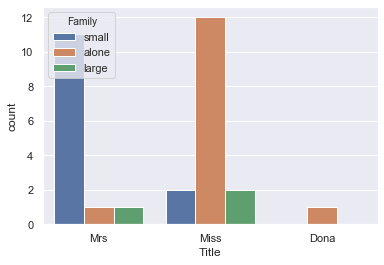

In [316]:
sns.countplot(x='Title', hue='Family', data=data[(data['Sex']=='female') & (data['Embarked']=='C') & 
                                   (data['Fare'] >=100) & (data['Embarked']=='C')])

In [317]:
# Changing the title to Miss
data.loc[1305, 'Title'] = 'Miss'

In [318]:
# Incorporating some titles into bigger groups
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

data.Title = data.Title.replace(Title_Dictionary)
data.pop('Name');

In [319]:
# Grouping the data to make a more informed imputing of missing values
grouped_data = data.groupby(['Sex', 'Pclass', 'Title']).mean()
grouped_data = grouped_data.reset_index()
grouped_data.head()

,Sex,Pclass,Title,Age,SibSp,Parch,Fare
0,female,1,Miss,30.274194,0.333333,0.492063,127.632408
1,female,1,Mrs,42.926471,0.743590,0.474359,96.955288
2,female,1,Officer,49.000000,0.000000,0.000000,25.929200
3,female,1,Royalty,40.500000,0.500000,0.000000,63.050000
4,female,2,Miss,20.717083,0.400000,0.640000,22.571500


In [320]:
data['Age'] = data.apply(
    lambda row: grouped_data[(row['Sex'] == grouped_data['Sex']) 
                             & (row['Pclass'] == grouped_data['Pclass'])
                             & (row['Title'] == grouped_data['Title'])]['Age'].values[0]
    if np.isnan(row['Age']) else row['Age'],
    axis=1)

In [321]:
#Checking for missing data
NAs = pd.concat([data.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Fare,1
Embarked,2


In [322]:
# Filling the 'Embarked' missing values with the most frequent ones
data['Embarked'] = data['Embarked'].fillna('S')

In [323]:
#Checking for missing data
NAs = pd.concat([data.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Fare,1


In [324]:
# Imputing of missing values in the Fare column using the grouped data from before
data['Fare'] = data.apply(
    lambda row: grouped_data[(row['Sex'] == grouped_data['Sex']) 
                             & (row['Pclass'] == grouped_data['Pclass'])
                             & (row['Title'] == grouped_data['Title'])]['Fare'].values[0]
    if np.isnan(row['Fare']) else row['Fare'],
    axis=1)

In [325]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
0,3,male,22.0,1,0,7.2500,S,small,Mr
1,1,female,38.0,1,0,71.2833,C,small,Mrs
2,3,female,26.0,0,0,7.9250,S,alone,Miss
3,1,female,35.0,1,0,53.1000,S,small,Mrs
4,3,male,35.0,0,0,8.0500,S,alone,Mr


In [326]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

numerical_features = list(X.select_dtypes(include=['int64', 'float64', 'int32']).columns)
print(numerical_features)
ss = StandardScaler()
data[numerical_features] = ss.fit_transform(data[numerical_features])
data.head()

['Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
0,3,male,-0.561178,0.481288,-0.445,-0.503232,S,small,Mr
1,1,female,0.632241,0.481288,-0.445,0.734779,C,small,Mrs
2,3,female,-0.262823,-0.479087,-0.445,-0.490181,S,alone,Miss
3,1,female,0.408475,0.481288,-0.445,0.383225,S,small,Mrs
4,3,male,0.408475,-0.479087,-0.445,-0.487765,S,alone,Mr


In [327]:
# Encoding categorical features
data = pd.get_dummies(data, prefix_sep='_', drop_first=True)
data.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Family_large,Family_small,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,-0.561178,0.481288,-0.445,-0.503232,0,1,1,0,1,0,1,0,1,0,0,0
1,0.632241,0.481288,-0.445,0.734779,0,0,0,0,0,0,1,0,0,1,0,0
2,-0.262823,-0.479087,-0.445,-0.490181,0,1,0,0,1,0,0,1,0,0,0,0
3,0.408475,0.481288,-0.445,0.383225,0,0,0,0,1,0,1,0,0,1,0,0
4,0.408475,-0.479087,-0.445,-0.487765,0,1,1,0,1,0,0,0,1,0,0,0


In [328]:
# Separating again the train and test sets
X = data[:891]
Xtest = data[891:]

In [329]:
X.shape

(891, 16)

In [330]:
Xtest.shape

(418, 16)

# Modelling

Useful imports:

In [331]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## Feature selection 

We've come up to more than 30 features so far. This number is quite large.

When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:

It decreases redundancy among the data
It speeds up the training process
It reduces overfitting
Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.

In [332]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt', class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

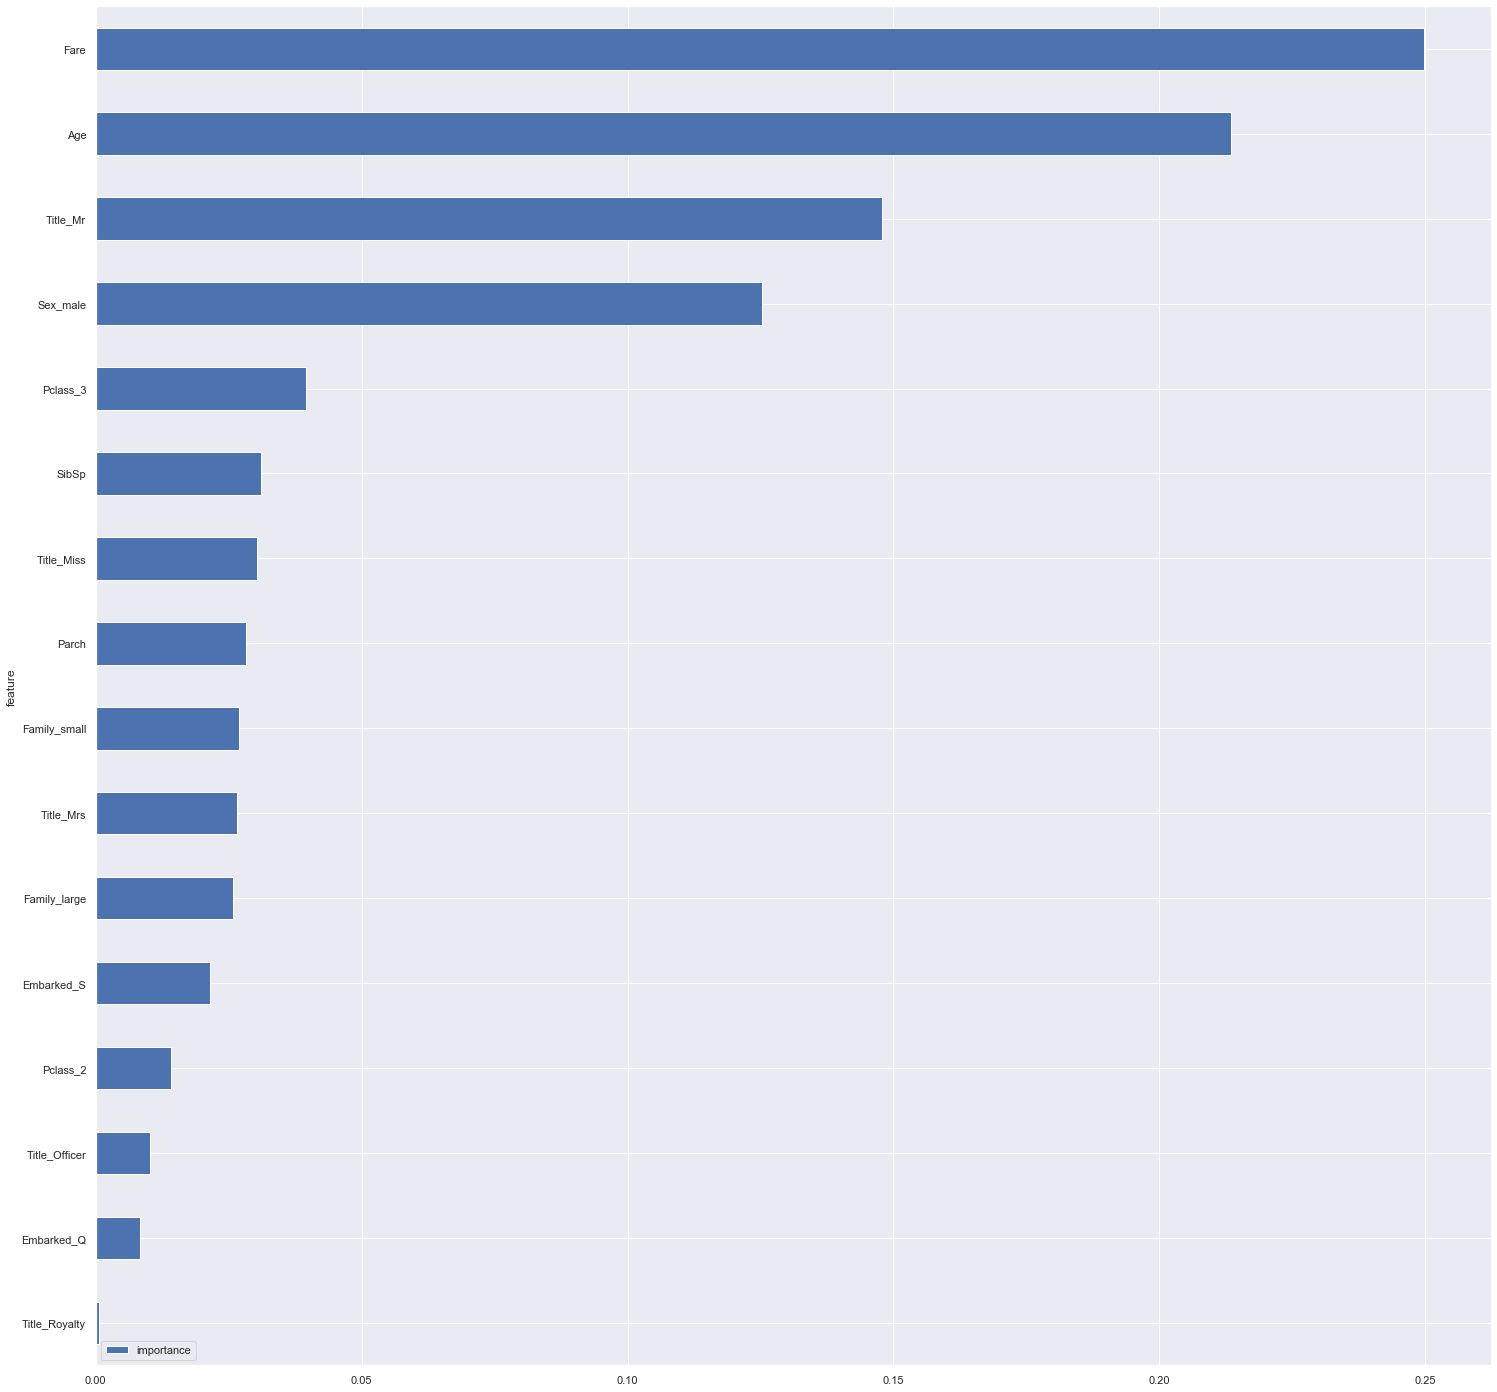

In [333]:
features = pd.DataFrame()
features['feature'] = Xtrain.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25));

In [82]:
#from sklearn.feature_selection import SelectFromModel

#model = SelectFromModel(clf, prefit=True)
#Xtrain_reduced = model.transform(Xtrain)
#print(Xtrain_reduced.shape)
# (891L, 14L)

#Xtest_reduced = model.transform(Xtest)
#print(Xtest_reduced.shape)
# (418L, 14L)

## Base models

## Some useful functions:

To evaluate our model we'll be using a 5-fold cross validation with the accuracy since it's the metric that the competition uses in the leaderboard.

To do that, we'll define a small scoring function.

In [334]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [335]:
from sklearn.metrics import confusion_matrix

def plot_confusion(ytest, y_model):
    """Plot the heatmap of the confusion_matrix(ytest, y_model)"""
    
    confusion = confusion_matrix(ytest, y_model)
    sns.heatmap(confusion, annot=True, square = True, cbar=False, cmap='YlGnBu')
    plt.xlabel('predicted values', size=14)
    plt.ylabel('true values', size=14)
    return plt.show()

In [336]:
def compare_accuracy(models, X, y):
    """Return a DataFrame with the accuracy for each model(hypermarameters)"""
    
    scores = pd.DataFrame() # Accuracy_score
    
    for name, model in models: # Models is a tuple of tuples ('model name', model(hyperparameters))
        scores[name] = cross_val_score(model, X, y, cv=5)
        
    return scores.mean()

In [337]:
from sklearn.model_selection import GridSearchCV

def parameter_tuning(model, Xtrain, ytrain, param_grid, cv=5, n_jobs=-1):
    """This function returns the best_parameter and the best estimator of the grid search
    Note: the param_grid must be defined accordingly to the model tested"""
    
    gs = GridSearchCV(model, param_grid, cv=cv, verbose=1, n_jobs=n_jobs, scoring='accuracy')
    gs.fit(Xtrain, ytrain)
    
    return gs.best_params_, gs.best_estimator_

## Base models 

The machine learning algorithms I am going to compare are:

- Gaussuan Naive Bayes
- Logistic Regression
- SVC
- K-Nearest Neighbors
- Decision Tree
- Random Forest
- Gradient Boost

In [338]:
gauss = GaussianNB()
logreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
#logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [gauss, logreg, svc, knn, dtc, rf, gboost]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=X, y=y, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.naive_bayes.GaussianNB'>
CV score = 0.803577929822359
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8260310087251271
****
Cross-validation of : <class 'sklearn.svm._classes.SVC'>
CV score = 0.8316364321134893
****
Cross-validation of : <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
CV score = 0.8114493754315486
****
Cross-validation of : <class 'sklearn.tree._classes.DecisionTreeClassifier'>
CV score = 0.7811311279894546
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.803577929822359
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8361496453455526
****


In [339]:
models = (('GNB', GaussianNB()), ('LOR', LogisticRegression()), ('SVC', SVC()), 
          ('KNN', KNeighborsClassifier()), ('DTC', DecisionTreeClassifier()),
          ('RFC', RandomForestClassifier()), ('GBO', GradientBoostingClassifier()))

accuracy = compare_accuracy(models, X, y)
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

## Hyperparameters tuning 

### Logistic Regression 

In [387]:
# Norm used in the penalization.
penalties = ['l1', 'l2']

# The regularization parameter. 
Cs = [10, 15, 20, 25, 30]

# Creating the parameter grid
param_grid = {'solver': ['liblinear']
              , 'penalty': penalties, 'C': Cs}

# Tuning the parameters
best_params_LOR, tuned_LOR = parameter_tuning(LogisticRegression(random_state=1), 
                                              X, y, param_grid, cv=StratifiedKFold(n_splits=5))
best_params_LOR

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


{'C': 20, 'penalty': 'l1', 'solver': 'liblinear'}

In [385]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
dtype: float64

In [388]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

### Support Vector Machine 

Tuning the hyperparameters using `parameter_tuning`:

In [461]:
# The regularization parameter. 
Cs = [0.3, 0.35, 0.4, 0.45, 0.5]

kernel=['poly', 'rbf']
gamma = ['scale', 'auto']
degree = [2,3,4,5]
# Creating the parameter grid
param_grid = {'C': Cs, 'kernel': kernel, 'gamma': gamma, 
              'degree': degree}

# Tuning the parameters
best_params_SVC, tuned_SVC = parameter_tuning(SVC(random_state=1, probability=True), 
                                              X, y, param_grid, cv=StratifiedKFold(n_splits=5))
best_params_SVC

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   29.2s finished


{'C': 0.35, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

In [462]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR), ('tuned_SVC', tuned_SVC))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
tuned_SVC    0.833877
dtype: float64

In [463]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

### K-Nearest Neighbors

In [416]:
## Number of neighbors to use by default for kneighbors queries.
n_neighbors = [3, 5, 11, 19, 21]
# Weight function used in prediction. 
weights = ['uniform', 'distance']
# The distance metric to use for the tree.
metrics = ['euclidean', 'minkowski', 'manhattan']
# Algorithm used to copute the nearest neighbor
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Creating the parameter grid
param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'metric': metrics,
              'algorithm': algorithms}

# Tuning the parameters
best_params_KNN, tuned_KNN = parameter_tuning(KNeighborsClassifier(), X, y, param_grid, cv=StratifiedKFold(n_splits=5))
best_params_KNN

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    7.0s finished


{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 21,
 'weights': 'uniform'}

In [417]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR), ('tuned_SVC', tuned_SVC), 
          ('tuned_KNN', tuned_KNN))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
tuned_SVC    0.833877
tuned_KNN    0.818185
dtype: float64

In [198]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.817061
DTC    0.765426
RFC    0.802454
GBO    0.836143
dtype: float64

### Decision Tree

In [419]:
# Maximum number of levels in tree
max_depth = np.arange(1, 11)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Grow a tree with max_leaf_nodes in best-first fashion
max_leaf_nodes = list(range(15, 35))


# Creating the parameter grid
param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'max_leaf_nodes': max_leaf_nodes}

# Tuning the parameters
best_params_DTC, tuned_DTC = parameter_tuning(DecisionTreeClassifier(random_state=1), X, y, param_grid, cv=StratifiedKFold(n_splits=5))
best_params_DTC

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   14.7s finished


{'max_depth': 3, 'max_leaf_nodes': 15, 'min_samples_split': 2}

In [420]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR), ('tuned_SVC', tuned_SVC), 
          ('tuned_KNN', tuned_KNN), ('tuned_DTC', tuned_DTC))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
tuned_SVC    0.833877
tuned_KNN    0.818185
tuned_DTC    0.822654
dtype: float64

In [421]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

### Random Forest 

Now we will tune the hyperparameters of `RandomForestClassifier`

In [464]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(20, 30, 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [15, 20, 25]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [25, 30, 35]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Creating the parameter grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# Tuning the parameters
best_params_RFC, tuned_RFC = parameter_tuning(RandomForestClassifier(random_state=1), X, y, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
best_params_RFC

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1551 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2451 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 2873 out of 2880 | elapsed:   58.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   58.3s finished


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 30,
 'n_estimators': 26}

In [465]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR), ('tuned_SVC', tuned_SVC), 
          ('tuned_KNN', tuned_KNN), ('tuned_DTC', tuned_DTC), ('tuned_RFC', tuned_RFC))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
tuned_SVC    0.833877
tuned_KNN    0.818185
tuned_DTC    0.822654
tuned_RFC    0.838397
dtype: float64

In [466]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

### Gradient Boosting Classifier 

In [467]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.35, 0.4, 0.45],
    "min_samples_split": np.linspace(0.05, 0.15, 4),
    "min_samples_leaf": np.linspace(0.001, 0.02, 4),
    "max_depth":[2, 3, 4],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.85],
    "n_estimators":[40, 50, 60]
    }

# Tuning the parameters
best_params_GBO, tuned_GBO = parameter_tuning(GradientBoostingClassifier(random_state=1), X, y, 
                                              parameters, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
best_params_GBO

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 4466 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4916 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5466 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6116 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6866 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 7716 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  7.3min finished


{'criterion': 'friedman_mse',
 'learning_rate': 0.4,
 'loss': 'deviance',
 'max_depth': 2,
 'max_features': 'log2',
 'min_samples_leaf': 0.007333333333333333,
 'min_samples_split': 0.08333333333333334,
 'n_estimators': 50,
 'subsample': 0.85}

### Comparing the models after the hyperparameter tuning 

In [470]:
models = (('GNB', GaussianNB()), ('tuned_LOR', tuned_LOR), ('tuned_SVC', tuned_SVC), ('tuned_KNN', tuned_KNN),
         ('tuned_DTC', tuned_DTC), ('tuned_RFC', tuned_RFC), ('tuned_GBO', tuned_GBO))

accuracy_tuned = compare_accuracy(models, X, y)
accuracy_tuned

GNB          0.803578
tuned_LOR    0.829402
tuned_SVC    0.833877
tuned_KNN    0.818185
tuned_DTC    0.822654
tuned_RFC    0.838397
tuned_GBO    0.854096
dtype: float64

In [471]:
accuracy

GNB    0.803578
LOR    0.826031
SVC    0.831636
KNN    0.811449
DTC    0.775538
RFC    0.797960
GBO    0.836150
dtype: float64

# My Predictions 

In [472]:
Xtest.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Family_large,Family_small,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
891,0.371181,-0.479087,-0.445000,-0.492034,0,1,1,1,0,0,0,0,1,0,0,0
892,1.303539,0.481288,-0.445000,-0.508065,0,1,0,0,1,0,1,0,0,1,0,0
893,2.422369,-0.479087,-0.445000,-0.456105,1,0,1,1,0,0,0,0,1,0,0,0
894,-0.188234,-0.479087,-0.445000,-0.475923,0,1,1,0,1,0,0,0,1,0,0,0
895,-0.561178,0.481288,0.710763,-0.405837,0,1,0,0,1,0,1,0,0,1,0,0


In [444]:
tuned_GBO.fit(X, y)
y_predict = tuned_RFC.predict(Xtest)

In [445]:
test['Survived'] = y_predict
test['PassengerId'] = index
predictions = test[['PassengerId', 'Survived']]
predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [446]:
predictions.to_csv('predictions_gbo.csv', index=False)

# Blending 

In [473]:
trained_models = []

models = [tuned_SVC, tuned_RFC, tuned_GBO]
for model in models:
    model.fit(X, y)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(Xtest)[:, 1])
    

    
predictions_df = pd.DataFrame(predictions).T
predictions_df.head()
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = index
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

predictions_df.head()
#predictions_df.to_csv('./predictions/blending_base_models.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [475]:
predictions_df.to_csv('predictions_blended.csv', index=False)